# Trace, Wavelength Calibrate, and Measure Line Properties of a spectrum

This tutorial assumes you have gone through the Trace and Wavelength Calibration tutorials

Repeat the trace-and-extract process derived in trace:

In [1]:
from PIL import Image
import numpy as np
import pylab as pl
pl.style.use('dark_background')

In [2]:
image_array_2 = np.array(Image.open('deneb_3s_13.63g_1.bmp'))

In [3]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter
linfitter = LinearLSQFitter()

In [4]:
# slice out the spectrum, calculate moments, and fit a trace
yaxis2 = np.repeat(np.arange(470, 520)[:,None], image_array_2.shape[1], axis=1)
xvals = np.arange(image_array_2.shape[1])
weighted_yaxis_values2 = np.average(yaxis2, axis=0, weights=image_array_2[470:520,:] - np.median(image_array_2))
polymodel2 = Polynomial1D(degree=3)
fitted_polymodel2 = linfitter(polymodel2, xvals, weighted_yaxis_values2)
trace_center2 = fitted_polymodel2(xvals)

In [5]:
# cut out the spectrum along the trace and compute a trace profile
npixels_to_cut = 15
trace_center = fitted_polymodel2(xvals)
cutouts = np.array([image_array_2[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)])
mean_trace_profile = cutouts.mean(axis=0)

In [6]:
# extract the trace-weighted profile as a spectrum
spectrum2 = np.array([np.average(image_array_2[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=mean_trace_profile)
                     for yval, ii in zip(trace_center2, xvals)])

Retrieve the wavelength solution from the wavelength tutorials

In [7]:
from astropy.modeling.models import Linear1D
wlmodel = Linear1D(slope=-0.10213643, intercept=562.3862495)

In [8]:
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f6ddc0f9490>

In [9]:
wavelengths = wlmodel(xvals) * u.nm

Text(0, 0.5, 'Intensity (arbitrary units)')

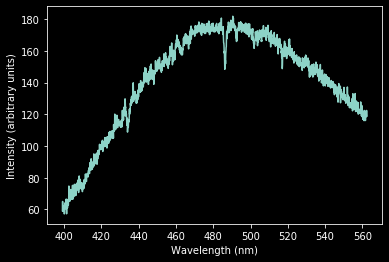

In [10]:
pl.plot(wavelengths, spectrum2)
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")

In [11]:
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter

Text(0, 0.5, 'Intensity (arbitrary units)')

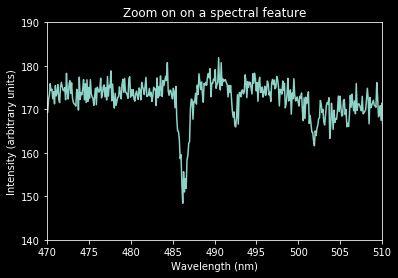

In [12]:
pl.title("Zoom on on a spectral feature")
pl.plot(wavelengths, spectrum2)
pl.axis([470,510,140,190])
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")

## Measuring things

We have extracted a spectrum that contains spectral lines.  We can demonstrate some simple measurements.

Because this is a star with continuum emission, we have to fit the continuum and the spectral line together.

In [13]:
# fit a continuum model with an absorption line using astropy's compound modeling tools
absorption_model_guess = (Linear1D(slope=0, intercept=175) +
                          Gaussian1D(amplitude=-25, mean=486, stddev=3))

Text(0, 0.5, 'Intensity (arbitrary units)')

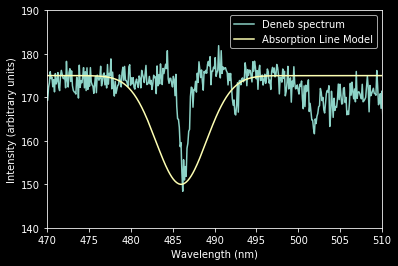

In [14]:
pl.plot(wavelengths, spectrum2, label="Deneb spectrum")
pl.plot(wavelengths, absorption_model_guess(wavelengths.value), label='Absorption Line Model')
pl.axis([470,510,140,190])
pl.legend(loc='best')
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")

In [15]:
# fit the absorption line model to the cutout region around the line
lmfitter = LevMarLSQFitter()
selection = (wavelengths > 470*u.nm) & (wavelengths < 500*u.nm) 
fitted_absorption_model = lmfitter(model=absorption_model_guess,
                                   x=wavelengths.value[selection],
                                   y=spectrum2[selection])

Text(0, 0.5, 'Intensity (arbitrary units)')

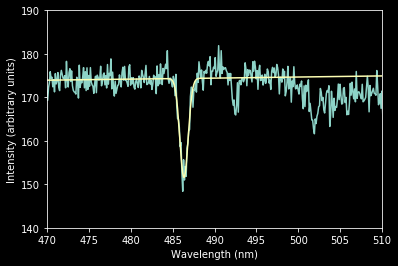

In [16]:
pl.plot(wavelengths, spectrum2)
pl.plot(wavelengths, fitted_absorption_model(wavelengths.value))
pl.axis([470,510,140,190])
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")

In [17]:
# split our compound model into two components
continuum_fit, absorption_fit = fitted_absorption_model
fitted_absorption_model, continuum_fit, absorption_fit

(<CompoundModel(slope_0=0.02444444, intercept_0=162.45685981, amplitude_1=-22.81529847, mean_1=486.34296327, stddev_1=0.4969129)>,
 <Linear1D(slope=0.02444444, intercept=162.45685981)>,
 <Gaussian1D(amplitude=-22.81529847, mean=486.34296327, stddev=0.4969129)>)

Text(0, 0.5, 'Intensity (arbitrary units)')

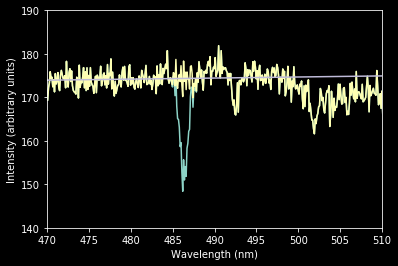

In [18]:
# show the spectrum before and after subtracting the line
pl.plot(wavelengths, spectrum2)
pl.plot(wavelengths, spectrum2 - absorption_fit(wavelengths.value))
pl.plot(wavelengths, continuum_fit(wavelengths.value))
pl.axis([470,510,140,190])
pl.xlabel("Wavelength (nm)")
pl.ylabel("Intensity (arbitrary units)")

Text(0, 0.5, 'Normalized Intensity')

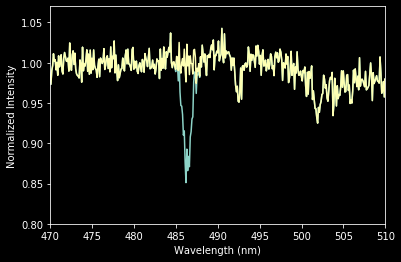

In [19]:
# show the spectrum normalized by the continuum
pl.plot(wavelengths, spectrum2 / continuum_fit(wavelengths.value))
residual_normalized = (spectrum2 - absorption_fit(wavelengths.value)) / continuum_fit(wavelengths.value)
pl.plot(wavelengths, residual_normalized)
pl.axis([470,510,0.8, 1.07])
pl.xlabel("Wavelength (nm)")
pl.ylabel("Normalized Intensity")

We can calculate the *equivalent width*, which is defined as the width of an absorption line that goes all the way to zero that has the same integral as our calculated line profile.

In other words, the EQW is the (negative) integral of the absorption line in normalized units.

## Equivalent Width

<img src="http://ircamera.as.arizona.edu/astr_250/images/eq_width.gif">

In [20]:
EQW =  (-absorption_fit(wavelengths.value[selection]).sum() /
        continuum_fit(wavelengths.value[selection]).mean()) * u.nm
EQW

<Quantity 1.59619625 nm>

The uncertainty on the EQW can be calculated simply assuming uncorrelated errors in adjacent pixels.   If the error per pixel is $\sigma_{pix}$, the uncertainty on the continuum-normalized spectru is $\sigma_{pix}/S_{continuum}$, so the uncertainty on the EQW is
$$\sigma_{EQW} = \left(\Sigma \frac{\sigma_{pix}^2}{S_{continuum}^2}\right)^{1/2}$$

In [21]:
per_pixel_normalized_uncertainty = residual_normalized[selection].std()
eqw_error = (per_pixel_normalized_uncertainty**2).sum()**0.5 * u.nm
print(f"EQW = {EQW:0.3f} +/- {eqw_error:0.3f}")

EQW = 1.596 nm +/- 0.013 nm


In [22]:
# we can also look at the wavelength and width of the absorption line:
absorption_fit

<Gaussian1D(amplitude=-22.81529847, mean=486.34296327, stddev=0.4969129)>

In [23]:
air_wavelength_hbeta = 486.135*u.nm # wikipedia https://en.wikipedia.org/wiki/Balmer_series

In [24]:
from astropy import constants

What's the velocity of our observed absorption line?

In [25]:
doppler_velocity = (absorption_fit.mean*u.nm -
                    air_wavelength_hbeta) / (air_wavelength_hbeta) * constants.c
doppler_velocity.to(u.km/u.s)

<Quantity 128.24795739 km / s>

In [26]:
# same answer, but using the astropy Doppler equivalency
doppler_velocity = (absorption_fit.mean*u.nm).to(u.km/u.s,
                                                 u.doppler_optical(air_wavelength_hbeta))
doppler_velocity

<Quantity 128.24795739 km / s>

In [27]:
# what's the linewidth?
linewidth_kms = (absorption_fit.stddev*u.nm) / air_wavelength_hbeta * constants.c.to(u.km/u.s)
linewidth_kms

<Quantity 306.43903635 km / s>

We can (and should) also estimate the statistical uncertainty on these measurements.

In [28]:
fitted_absorption_model

<CompoundModel(slope_0=0.02444444, intercept_0=162.45685981, amplitude_1=-22.81529847, mean_1=486.34296327, stddev_1=0.4969129)>

In [29]:
(slope_variance, intercept_variance,
 amplitude_variance, centroid_variance,
 width_variance) = lmfitter.fit_info['param_cov'].diagonal()

In [30]:
velocity_centroid_error = ((centroid_variance**0.5) / absorption_fit.mean * constants.c).to(u.km/u.s)
print(f"Centroid velocity = {doppler_velocity:0.0f} +/- {velocity_centroid_error:0.0f}")

Centroid velocity = 128 km / s +/- 15 km / s


DONE.  You're a spectroscopist now.